In [1]:
from matchms.importing import load_from_msp
from RIAssigner.data import PandasData, MatchMSData
from RIAssigner.compute import CubicSpline
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from matchms.importing import load_from_msp, load_from_mgf
from matchms.filtering import add_precursor_mz, add_retention_index, add_retention_time
from matchms.exporting import save_as_msp
import pandas
from scipy.interpolate import CubicSpline as Model



In [2]:
spectra = list(load_from_msp("..\\tests\\data\\msp\\recetox_gc-ei_ms_20201028.msp"))

In [3]:
ref = PandasData("..\\tests\\data\\csv\\Alkanes_20210325.csv", "csv", "min")
cols = ref._data.columns
labels = ref._data.loc[:,cols[0]].tolist()

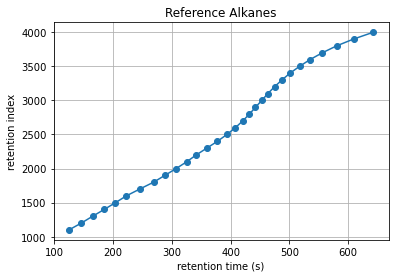

In [4]:
fig, ax = plt.subplots()
ax.plot(ref.retention_times, ref.retention_indices, '-o', data=labels)
ax.set(xlabel='retention time (s)', ylabel='retention index', title='Reference Alkanes')
ax.grid()
plt.show()

In [7]:
alkanes_data = ref._data
fig = px.scatter(alkanes_data, x="RT", y="retention_index", text=alkanes_data[alkanes_data.columns[0]], width = 800, height = 800)
fig.update_traces(textposition="bottom right")

fig.show()

In [11]:
library = list(load_from_msp("..\\tests\\data\\msp\\recetox_gc-ei_ms_20201028.msp"))
filtered_spectra = [add_retention_index(x) for x in library]
filtered_spectra = [add_precursor_mz(x) for x in filtered_spectra]
spectra_metadata = [x.metadata for x in filtered_spectra][20:50]
data = pandas.DataFrame(spectra_metadata)

In [12]:
fig = px.scatter(data, x="retention_index", y="precursor_mz", text=data["name"])
fig.update_traces(textposition="bottom right")


fig.show()

In [50]:
deconv_spectra = list(map(add_retention_time, map(add_retention_index, load_from_msp("data\\deconvoluted_spectra_v3.msp"))))
names = [x.get("name") for x in deconv_spectra]
annotation_table = pandas.read_csv("data\\annotations_v3.tsv", sep = None)

In [51]:
def find_spectrum(name, spectra):
    for elem in spectra:
        if elem.get("name") == name:
            return elem.clone()
    return None


In [52]:
print(find_spectrum("C0006", deconv_spectra))
names = [x.get("name") for x in deconv_spectra]
names.index("C0006")

1519

In [53]:
named = []
queries = list(annotation_table["query"])
references = list(annotation_table["reference"])
tup = list(zip(queries, references))


for q, ref in tup:
    spectrum = find_spectrum(q, deconv_spectra)
    if spectrum is None:
        print(q)
    spectrum.set("name", ref)
    spectrum.set("group", "annotation")
    named.append(spectrum)

In [54]:
spectra_copy = [find_spectrum(str(x), deconv_spectra) for x in queries]

In [55]:
metabolite_lib = list(load_from_msp("data\\metabolite_lib.msp"))
metabolite_lib_annotations = list(filter(lambda x: x.get("name") in list(annotation_table["reference"]), metabolite_lib))
metabolite_lib_spectra = [add_retention_index(x).metadata for x in metabolite_lib_annotations]
metabolite_lib_data = pandas.DataFrame(metabolite_lib_spectra)
metabolite_lib_data["group"] = "library"


In [56]:
annotation_data = pandas.DataFrame([add_retention_index(x).metadata for x in named])
annotation_data["group"] = "annotation"

In [57]:
merged_data = pandas.concat([metabolite_lib_data, annotation_data])

In [58]:
fig = px.scatter(merged_data, x="name", y="retention_index", color = "group")

fig.show()

In [59]:
metabolite_subframe = metabolite_lib_data[["name", "retention_index"]]
annotation_subframe = annotation_data[["name", "retention_time"]]
annotation_df = pandas.merge(metabolite_subframe, annotation_subframe)

In [61]:
fig = px.scatter(annotation_df, x="retention_time", y="retention_index", text="name")
fig.update_traces(textposition="bottom right")

fig.show()

In [10]:
biswa_alkanes = PandasData("data/biswa_alkanes.tsv", filetype="tsv", rt_unit="min")
biswa_alkanes = pandas.DataFrame({ "rt":biswa_alkanes.retention_times, "ri": biswa_alkanes.retention_indices })

In [96]:
mtbls370_alkanes = PandasData("data/mtbls370_alkanes.csv", filetype="csv", rt_unit="min")
mtbls370_alkanes = pandas.DataFrame({ "rt": mtbls370_alkanes.retention_times, "ri": mtbls370_alkanes.retention_indices })

C:\Users\473355\Miniconda3\lib\site-packages\pandas\core\construction.py:564: UnitStrippedWarning:

The unit of the quantity is stripped when downcasting to ndarray.



In [97]:
n_alkanes = 17
dbs_alkanes = PandasData("data/dbs_alkanes.tsv", filetype="tsv", rt_unit="min")
dbs_alkanes = pandas.DataFrame({ "rt": dbs_alkanes.retention_times[:n_alkanes], "ri": dbs_alkanes.retention_indices[:n_alkanes] })

In [3]:
dbs_annotations = list(filter(lambda x: x.get("title") != "Unknown", load_from_mgf("data/dbs_annotations.mgf")))
save_as_msp(dbs_annotations, "data/dbs_annotations.msp")

In [98]:
common_annotations = {
    #"Succinic acid, 2TMS": [[2.7424, 1303.341],[9.08, 1307.212057]],
    "Serine_3TMS": [[2.929473, 1363.477], [9.61, 1378.274524]],
    "Aspartic Acid_3TMS": [[3.421559, 1513.406], [10.75, 1548.64736]],
    "Xylose_4TMS": [[3.886427, 1649.754], [11.43, 1661.375318]],
    "2-Deoxyglucose_4TMS": [[4.338606, 1772.302], [12.08, 1776.88329]],
    "D27-Myristic acid_TMS": [[4.52738, 1824.962], [12.32, 1821.454146]],
    "Fructose_5TMS": [[4.669699, 1865.776], [12.62, 1878.628721]],
    "Sorbitol_6TMS": [[4.89183, 1932.874], [12.9, 1933.458685]],
    "Palmitic acid_1TMS": [[5.235894, 2042.023], [13.42, 2039.051952]],
    "Myo-inositol_6TMS": [[5.368965, 2086.329], [13.65, 2087.321589]],
    "Stearic acid_1TMS": [[5.789268, 2237.198], [14.33, 2235.661613]],
    "Sucrose_8TMS": [[6.848479, 2629.458], [15.92, 2615.516127]]
}

In [105]:
fig = go.Figure([
    go.Scatter(
        name='MTBLS370',
        x=mtbls370_alkanes['rt'],
        y=mtbls370_alkanes['ri'],
        mode='lines',
        showlegend=True
    ),
    go.Scatter(
        name='RCX',
        x=dbs_alkanes['rt'],
        y=dbs_alkanes['ri'],
        mode='lines',
        showlegend=True
    )
])

for idx, key in enumerate(common_annotations):
    value = common_annotations[key]
    # fig.add_shape(
    #     type="line",
    #     x0 = value[0][0] * 60.0,
    #     y0 = value[0][1],
    #     x1 = value[1][0] * 60.0,
    #     y1 = value[1][1],
    #     line=dict(color='Red', width=1, dash="dot"),
    # )
    a = float(1.0 / len(common_annotations)) * idx
    b = 1 - a
    weighted_middle = (b * value[0][0] + a * value[1][0]) * 60.0
    middle =  0.5 * (value[0][0] + value[1][0]) * 60.0
    fig.add_annotation(
        x = middle,
        y = value[0][1],
        text=key,
        showarrow=False,
        arrowhead=1)

    start_x = value[0][0] * 60.0
    start_y = value[0][1]

    end_x = value[1][0] * 60
    end_y = value[1][1]

    diff_x = end_x - start_x
    diff_y = end_y - start_y

    fig.add_annotation(
        ax = middle + 75,
        ay = value[0][1],
        x = end_x,
        y = end_y,
        xref="x",
        yref="y",
        axref="x",
        ayref="y",
        showarrow=True,
        arrowhead=1)
    
    fig.add_annotation(
        ax = middle - 75,
        ay = value[0][1],
        x = start_x,
        y = start_y,
        xref="x",
        yref="y",
        axref="x",
        ayref="y",
        showarrow=True,
        arrowhead=1)

    fig.add_annotation(
        x = start_x-45,
        y = start_y,
        text = str(start_y),
        showarrow=False,
        arrowhead=1)

    fig.add_annotation(
        x = end_x+55,
        y = end_y,
        text = str(end_y),
        showarrow=False,
        arrowhead=1)
    

fig.update_layout(
    yaxis_title='Retention Index',
    xaxis_title='Retention Time (s)',
    hovermode="x",
    height=800,
    width=1000
)
fig.show()